Import Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import gc  # Gabage collector for cleaning deleted data from memory
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img


Using TensorFlow backend.


Define Functions

- @ get_data_paths : Function to get full paths for training/test data

- @ get_directory: Function to check what is your current directory

- @ plot_sample: Function to plot raw images

- @ read_and_process_image: Function to import and process images given paths

- @ plot_multiple_pics: Function to plot processed images

- @ plot_labels: Function to see distribution of cats and dogs

- @ split_data: Function to split data into train and test

- @ init_model: Function to create cnn architecture

- @ process_images: Function to process images for modeling

In [25]:
# Functions

# A function to get paths
def get_data_paths(base_path, data_path, sample_size):

    train_dir, test_dir = base_path + data_path[0], base_path + data_path[1]
    train_fullpath, test_fullpath = train_dir + '/{}', test_dir + '/{}'

    train_dogs = [train_fullpath.format(i) for i in os.listdir(train_dir) if 'dog' in i]  # get dog images
    train_cats = [train_fullpath.format(i) for i in os.listdir(train_dir) if 'cat' in i]  # get cat images

    # TODO what to do with test_imgs
    test_imgs = [test_fullpath.format(i) for i in os.listdir(test_dir)]  # get test images

    train_imgs = train_dogs[:sample_size] + train_cats[:sample_size]  # slice the dataset and use 2000 in each class
    random.shuffle(train_imgs)  # shuffle it randomly

    # Clear list that are useless
    del train_dogs
    del train_cats
    gc.collect()  # collect garbage to save memory

    return train_imgs, test_imgs

# A function to get directories
def get_directory():
    dirpath = os.getcwd()
    print("current directory is : " + dirpath)
    foldername = os.path.basename(dirpath)
    print("Directory name is : " + foldername)

# Plot some images without any preprocessing
def plot_sample(images, sample_size):
    for ima in images[:sample_size]:
        img = mpimg.imread(ima)
        imgplot = plt.imshow(img)
        plt.show()

# A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images, nrows, ncolumns):
    """
    Returns two arrays:
        X is an array of resized images
        y is an array of labels
    """
    X = []  # images
    y = []  # labels

    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns),
                            interpolation=cv2.INTER_CUBIC))  # Read the image
        # get the labels
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)

    return np.array(X), np.array(y)

# Plot some processed images
def plot_multiple_pics(images, columns=5):
    # Lets view some of the pics
    plt.figure(figsize=(20, 10))
    for i in range(columns):
        plt.subplot(columns / columns + 1, columns, i + 1)
        plt.imshow(images[i])

# Plot labels
def plot_labels(labels):
    # Lets plot the label to be sure we just have two class
    sns.countplot(labels)
    plt.title('Labels for Cats and Dogs')

# Split into train and test data
def split_data(x, y, test_size=0.20, random_state=2):
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=random_state)
    print("Shape of train images is:", X_train.shape)
    print("Shape of validation images is:", X_val.shape)
    print("Shape of labels is:", y_train.shape)
    print("Shape of labels is:", y_val.shape)
    return X_train, X_val, y_train, y_val

# Set up an architecture
def init_model(input_shape, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))  # Dropout for regularization
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Augment data 
def process_images(x_train, y_train, x_test, y_test, batch_size):
    train_datagen = ImageDataGenerator(rescale=1. / 255,  # Scale the image between 0 and 1
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

    val_datagen = ImageDataGenerator(rescale=1. / 255)  # We do not augment validation data. we only perform rescale

    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
    test_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)
    return train_generator, test_generator

def plot_history(history):
    # lets plot the train and val curve
    # get the details form the history object
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    # Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()



Getting Data


In [9]:

# Parameters for the data

# Paths
base_path = '../data/perrosygatos/'
data_path = ['train', 'test1']

# Lets declare our image dimensions we are using coloured images.
n_rows = 150
n_columns = 150
channels = 3

# Sample Data for fast prototyping
sample_size = 2000

Shape of train images is: (4000, 150, 150, 3)
Shape of labels is: (4000,)


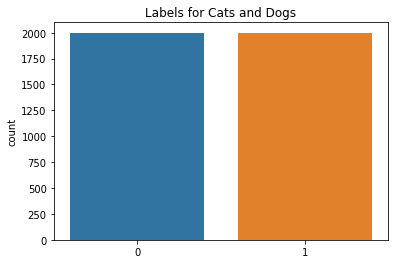

In [10]:
# Getting Data
train_images, test_images = get_data_paths(base_path, data_path, sample_size=sample_size)
X, y = read_and_process_image(train_images, n_rows, n_columns)
plot_labels(y)
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

In [11]:
# Split Data
X_train, X_val, y_train, y_val = split_data(X, y)
n_train = len(X_train)
n_val = len(X_val)

Shape of train images is: (3200, 150, 150, 3)
Shape of validation images is: (800, 150, 150, 3)
Shape of labels is: (3200,)
Shape of labels is: (800,)


In [27]:
# clearing memory
del train_images
del X
del y
gc.collect()


NameError: name 'train_images' is not defined

Starting Modeling 

In [21]:
# Parameters
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
batch_size = 8
dropout = 0.5
epochs = 5
learning_rate = 1e-4
loss_metric = 'binary_crossentropy'
validation_metric = 'acc'
input_shape = (n_rows, n_columns, channels)



In [22]:
model = init_model(input_shape, dropout)
model.summary()
model.compile(loss=loss_metric, optimizer=optimizers.RMSprop(lr=learning_rate), metrics=[validation_metric])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [23]:
train_generator, test_generator = process_images(X_train, y_train, X_val, y_val, batch_size=batch_size)



In [24]:
# The training part
history = model.fit_generator(train_generator,
                              steps_per_epoch=n_train // batch_size,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=n_val // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
400/400 [==============================] - 86s 214ms/step - loss: 0.6940 - acc: 0.5131 - val_loss: 0.6834 - val_acc: 0.5425
Epoch 2/5
400/400 [==============================] - 83s 206ms/step - loss: 0.6834 - acc: 0.5575 - val_loss: 0.6367 - val_acc: 0.6462
Epoch 3/5
400/400 [==============================] - 83s 208ms/step - loss: 0.6649 - acc: 0.6034 - val_loss: 0.6156 - val_acc: 0.6850
Epoch 4/5
400/400 [==============================] - 83s 208ms/step - loss: 0.6510 - acc: 0.6222 - val_loss: 0.6763 - val_acc: 0.5600
Epoch 5/5
400/400 [==============================] - 84s 210ms/step - loss: 0.6336 - acc: 0.6322 - val_loss: 0.5963 - val_acc: 0.6550


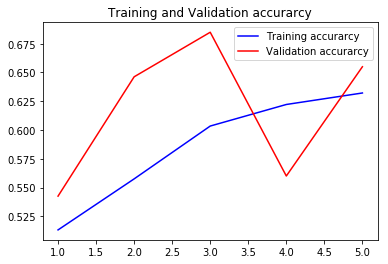

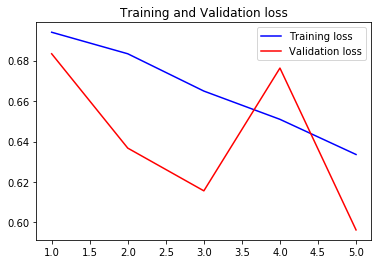

In [26]:
plot_history(history)

In [35]:
X_test, y_test = read_and_process_image(test_images[0:10], n_rows, n_columns) #Y_test in this case will be empty.



In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow(X_test, batch_size=1)

In [40]:

def predict_and_plot(model, test_generator, columns=5):
    text_labels = []
    plt.figure(figsize=(30, 20))
    for i, batch in enumerate(test_generator):
        pred = model.predict(batch)
        if pred > 0.5:
            text_labels.append('dog')
        else:
            text_labels.append('cat')
        plt.subplot(5 / columns + 1, columns, i + 1)
        plt.title('This is a ' + text_labels[i])
        imgplot = plt.imshow(batch[0])
        i += 1
        if i % 10 == 0:
            break
    plt.show()
    return text_labels

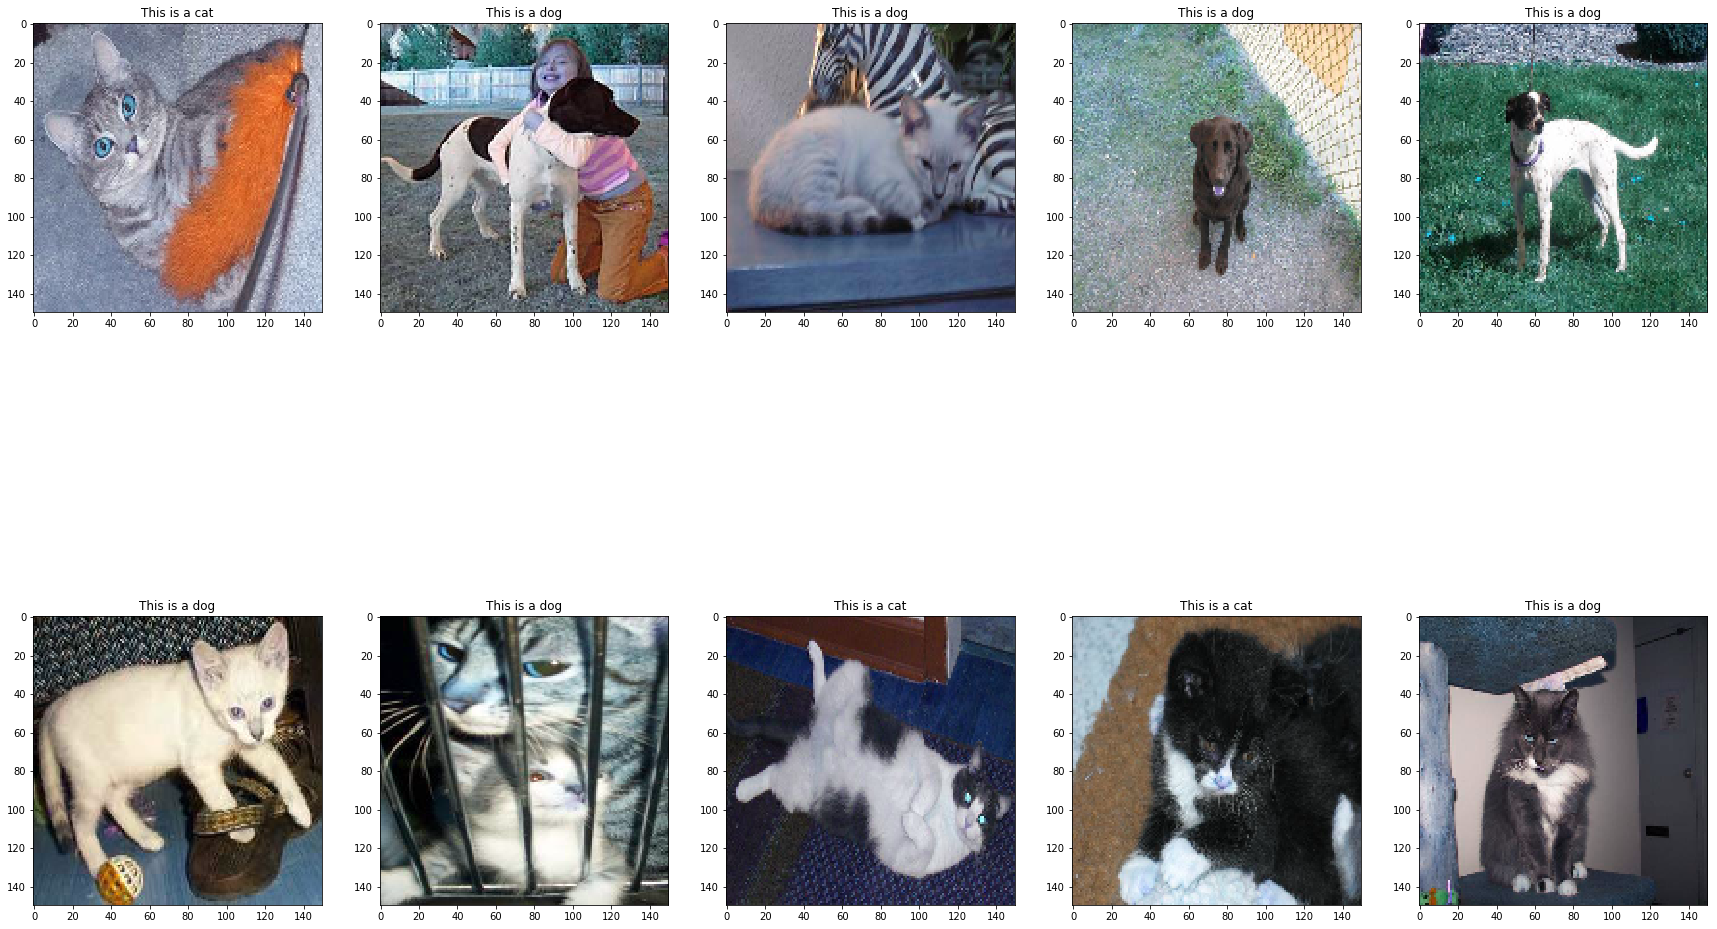

In [41]:
test_labels = predict_and_plot(model, test_gen)